# DML ATT Example

This notebook covers scenario:
| Is RCT        | Treatment | Outcome    | EDA | Estimands | Refutation |
|---------------|-----------|------------|-----|-----------|------------|
| Observational | Binary    | Continuous | Yes | ATT       | Yes        |

We will estimate Average Treatment Effect on Treated (ATT) of binary treatment on continuous outcome. It shows explonatary data analysis and refutation tests

## Generate data

Example that generates observational data with a nonlinear outcome model, nonlinear treatment assignment, and a heterogeneous (nonlinear) treatment effect tau(X). This setup ensures that ATT ≠ ATE in general. It also shows how to compute the “ground-truth” ATT from the generated data.

In [1]:
# Nonlinear ATT data generation with heterogeneous effects

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from causalkit.data import CausalDatasetGenerator, CausalData

# Reproducibility
np.random.seed(42)

# 1) Confounders and their distributions
#    These names define the column order in X for the custom functions.
confounder_specs = [
    {"name": "tenure_months",     "dist": "normal",   "mu": 24, "sd": 12},
    {"name": "avg_sessions_week", "dist": "normal",   "mu": 5,  "sd": 2},
    {"name": "spend_last_month",  "dist": "uniform",  "a": 0,   "b": 200},
    {"name": "premium_user",      "dist": "bernoulli","p": 0.25},
    {"name": "urban_resident",    "dist": "bernoulli","p": 0.60},
]

# Indices (for convenience inside g_y, g_t, tau)
TENURE, SESS, SPEND, PREMIUM, URBAN = range(5)

# 2) Nonlinear baseline for outcome f_y(X) = X @ beta_y + g_y(X)
#    Keep a modest linear part and add meaningful nonlinearities.
beta_y = np.array([
    0.03,   # tenure_months
    0.20,   # avg_sessions_week
    0.01,   # spend_last_month
    1.20,   # premium_user
    0.60,   # urban_resident
], dtype=float)

def g_y(X: np.ndarray) -> np.ndarray:
    # Nonlinearities and interactions in outcome baseline
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    return (
        1.2 * np.sin(2.0 * np.pi * tenure_years)          # seasonal-ish tenure pattern
        + 0.02 * (sessions - 5.0) ** 2                    # convex effect of sessions
        + 0.0015 * (spend - 100.0) * (sessions - 5.0)     # spend × sessions interaction
        + 0.4 * premium * (sessions - 5.0)                # premium × sessions interaction
        + 0.3 * urban * np.tanh((spend - 100.0) / 50.0)   # nonlinear spend effect differs by urban
    )

# 3) Nonlinear treatment score f_t(X) = X @ beta_t + g_t(X)
beta_t = np.array([
    0.010,  # tenure_months
    0.12,   # avg_sessions_week
    0.001,  # spend_last_month
    0.80,   # premium_user
    0.25,   # urban_resident
], dtype=float)

def g_t(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    # Smoothly increasing selection with spend; interactions make selection non-separable
    soft_spend = 1.2 * np.tanh((spend - 80.0) / 40.0)
    return (
        0.6 * soft_spend
        + 0.15 * (sessions - 5.0) * (tenure_years - 2.0)
        + 0.25 * premium * (urban - 0.5)
    )

# 4) Heterogeneous, nonlinear treatment effect tau(X) on the natural scale (continuous outcome)
def tau_fn(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    # Base effect + stronger effect for higher sessions and premium users,
    # diminishes with tenure, mild modulation by spend and urban
    tau = (
        1.0
        + 0.8 * (1.0 / (1.0 + np.exp(-(sessions - 5.0))))    # sigmoid in sessions
        + 0.5 * premium
        - 0.6 * np.clip(tenure_years / 5.0, 0.0, 1.0)        # taper with long tenure
        + 0.2 * urban * (spend - 100.0) / 100.0
    )
    # Optional: keep it in a reasonable range
    return np.clip(tau, 0.2, 2.5)

# 5) Noise and prevalence
sigma_y = 3.5
target_t_rate = 0.35  # enforce ~35% treated via intercept calibration

# 6) Build generator
gen = CausalDatasetGenerator(
    outcome_type="continuous",
    sigma_y=sigma_y,
    target_t_rate=target_t_rate,
    seed=42,
    # Confounders
    confounder_specs=confounder_specs,
    # Outcome/treatment structure
    beta_y=beta_y,
    beta_t=beta_t,
    g_y=g_y,
    g_t=g_t,
    # Heterogeneous effect
    tau=tau_fn,
)

# 7) Generate data (full dataframe includes ground-truth columns: propensity, mu0, mu1, cate)
n = 10000
generated_df = gen.generate(n)

# Ground-truth ATT (on the natural scale): E[tau(X) | T=1] = mean CATE among the treated
true_att = float(generated_df.loc[generated_df["t"] == 1, "cate"].mean())
print(f"Ground-truth ATT from the DGP: {true_att:.3f}")

# 8) Wrap as CausalData for downstream workflows (keeps only y, t, and specified confounders)
causal_data = CausalData(
    df=generated_df,
    treatment="t",
    outcome="y",
    confounders=[
        "tenure_months",
        "avg_sessions_week",
        "spend_last_month",
        "premium_user",
        "urban_resident",
    ],
)

# Peek at the analysis-ready view
causal_data.df.head()

Ground-truth ATT from the DGP: 1.386


,y,t,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident
0,2.237316,0.0,27.656605,5.352554,72.552568,1.0,0.0
1,5.771469,0.0,11.520191,6.798247,188.481287,1.0,0.0
2,6.374653,1.0,33.005414,2.055459,51.040440,0.0,1.0
3,2.364177,1.0,35.286777,4.429404,166.992239,0.0,1.0
4,8.378079,0.0,0.587578,6.658307,179.371126,0.0,0.0


## EDA


In [2]:
from causalkit.eda import CausalEDA
eda = CausalEDA(causal_data)

### General dataset information

Let's see how outcome differ between clients who recieved the feature and didn't

In [3]:
# shape of data
eda.data_shape()

{'n_rows': 10000, 'n_columns': 7}

In [4]:
# 1) Outcome statistics by treatment
eda.outcome_stats()

,count,mean,std,min,p10,p25,median,p75,p90,max
treatment,,,,,,,,,,
0.0,6529,3.187405,3.755011,-12.770866,-1.579354,0.699513,3.149450,5.720525,7.932562,17.323664
1.0,3471,5.221957,3.986130,-7.310514,0.152369,2.511003,5.205133,7.972448,10.350862,18.147842


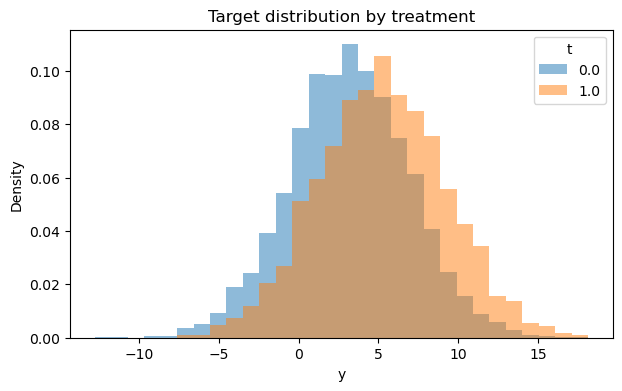

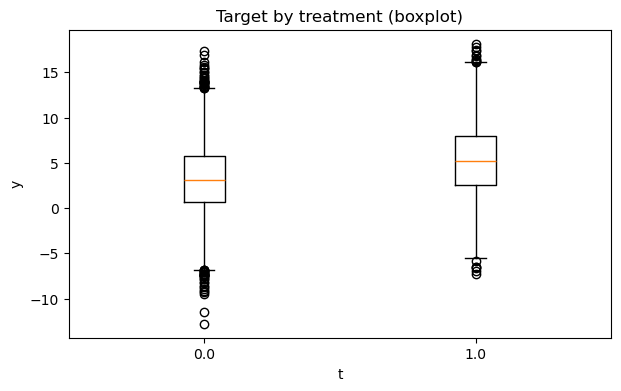

In [5]:
# 2) Outcome distribution by treatment (hist + boxplot)
fig1, fig2 = eda.outcome_plots()
plt.show()

### Propensity

Now let's examine how propensity score differ treatments

In [6]:
# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance_df = eda.confounders_means()
display(confounders_balance_df)

,mean_t_0,mean_t_1,abs_diff,smd
confounders,,,,
spend_last_month,90.246033,119.504887,29.258855,0.527431
premium_user,0.194823,0.354941,0.160118,0.364510
avg_sessions_week,4.903527,5.298734,0.395206,0.197970
urban_resident,0.576811,0.646211,0.069400,0.142734
tenure_months,23.337260,24.892263,1.555004,0.128836


In [7]:
# Propensity model fit
ps_model = eda.fit_propensity()

# ROC AUC - shows how predictable treatment is from confounders
roc_auc_score = ps_model.roc_auc
print("ROC AUC from PropensityModel:", round(roc_auc_score, 4))

ROC AUC from PropensityModel: 0.6924


In [8]:
# Positivity check - assess overlap between treatment groups
positivity_result = ps_model.positivity_check()
print("Positivity check from PropensityModel:", positivity_result)

Positivity check from PropensityModel: {'bounds': (0.05, 0.95), 'share_below': 0.0123, 'share_above': 0.0003, 'flag': False}


In [9]:
# SHAP values - feature importance for treatment assignment from confounders
shap_values_df = ps_model.shap
display(shap_values_df)

,feature,shap_mean,shap_mean_abs,odds_mult_abs,exact_pp_change_abs,exact_pp_change_signed
0,num__avg_sessions_week,-0.000709,0.231318,1.260259,0.053972,-0.000160
1,num__tenure_months,0.000493,0.176727,1.193305,0.040955,0.000111
2,num__premium_user,0.000182,0.350892,1.420334,0.082963,0.000041
3,num__urban_resident,0.000045,0.169130,1.184274,0.039157,0.000010
4,num__spend_last_month,-0.000011,0.571914,1.771655,0.137722,-0.000002


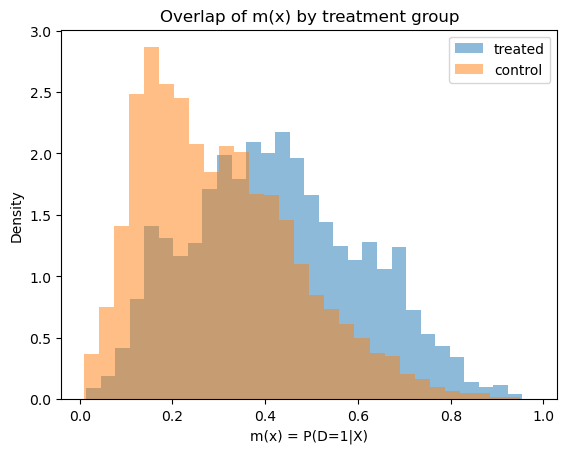

In [10]:
# Propensity score overlap graph
ps_model.ps_graph()
plt.show()

### Outcome regression

Let's analyze how confounders predict outcome

In [11]:
# Outcome model fit
outcome_model = eda.outcome_fit()

# RMSE and MAE of regression model
print(outcome_model.scores)

{'rmse': 3.644001419637874, 'mae': 2.9062081925949586}


In [12]:
# 2) SHAP values - feature importance for outcome prediction from confounders
shap_outcome_df = outcome_model.shap
display(shap_outcome_df)

,feature,shap_mean
0,premium_user,0.001251
1,spend_last_month,-0.001191
2,avg_sessions_week,-0.001137
3,tenure_months,0.000659
4,urban_resident,0.000418


# Inference

Now time to estimate ATE with Double Machine Learning

In [13]:
from causalkit.inference.atte import dml_atte

# Estimate Average Treatment Effect (ATT)
att_result = dml_atte(causal_data, n_folds=3, confidence_level=0.95)

In [14]:
att_result

{'coefficient': 1.2811744560034295,
 'std_error': 0.11952472711806723,
 'p_value': 0.0,
 'confidence_interval': (1.0469102955900398, 1.5154386164168192),
 'model': <causalkit.inference.estimators.irm.IRM at 0x15e557770>}

Real ATT is 1.385

In [15]:
from causalkit.inference.atte import dml_atte_source

# Estimate Average Treatment Effect (ATT)
att_result = dml_atte_source(causal_data, n_folds=3, confidence_level=0.95)
att_result


{'coefficient': 1.3388422571411907,
 'std_error': 0.09290445060655343,
 'p_value': 4.415346870522402e-47,
 'confidence_interval': (1.1567528799488656, 1.5209316343335157),
 'model': <doubleml.irm.irm.DoubleMLIRM at 0x15e557cb0>}

## Refutation

In [16]:
# Import refutation utilities
from causalkit.refutation import (
    refute_placebo_outcome,
    refute_placebo_treatment,
    refute_subset,
    refute_irm_orthogonality,
    sensitivity_analysis,
    sensitivity_analysis_set
)

### Placebo

Replacing outcome with dummy random variable must broke our model and effect will be near zero

In [17]:
# Replacing an outcome with placebo
att_placebo_outcome = refute_placebo_outcome(
    dml_atte_source,
    causal_data,
    random_state=42
)

print(att_placebo_outcome)

{'theta': -0.0012806280371837212, 'p_value': 0.7044798699944812}


Replacing treatment with dummy random variable must broke our model and effect will be near zero

In [18]:
# Replacing treatment with placebo
att_placebo_treatment = refute_placebo_treatment(
    dml_atte_source,
    causal_data,
    random_state=42
)

print(att_placebo_treatment)

{'theta': -0.029196210635696572, 'p_value': 0.7102486963099138}


Let's chanllege our dataset and romove random parts. Theta shoul be near estimated

In [19]:
# Inference on subsets
subset_fractions = [0.3, 0.5]

att_subset_results = []
for fraction in subset_fractions:
    subset_result = refute_subset(
        dml_atte_source,
        causal_data,
        fraction=fraction,
        random_state=42
    )
    att_subset_results.append(subset_result)

    print(f" With {fraction*100:.0f}% subset: theta = {subset_result['theta']:.4f}, p_value = {subset_result['p_value']:.4f}")

 With 30% subset: theta = 1.1100, p_value = 0.0000
 With 50% subset: theta = 1.4470, p_value = 0.0000


### Orthogonality

Orthogonality tests validate whether our ATT estimator is properly specified. We will inspect:
- Out-of-sample (OOS) moment check;
- ATT-specific orthogonality derivatives (m0 and g only);
- Influence diagnostics;
- ATT overlap diagnostics and trim-sensitivity near m→1 (controls);
- Trimming info and overall diagnostic conditions.

In [20]:
att_ortho_check = refute_irm_orthogonality(dml_atte, causal_data, target='ATTE')

/var/folders/m0/gys_jqqj44n801p04bgv_ct00000gn/T/ipykernel_28896/3020675057.py:1: DeprecationWarning: 'target' is deprecated; use 'score' ('ATE'|'ATTE').
  att_ortho_check = refute_irm_orthogonality(dml_att, causal_data, target='ATTE')
/var/folders/m0/gys_jqqj44n801p04bgv_ct00000gn/T/ipykernel_28896/3020675057.py:1: DeprecationWarning: 'clip_eps' is deprecated; use 'trimming_threshold'.
  att_ortho_check = refute_irm_orthogonality(dml_att, causal_data, target='ATTE')


### 1. Out-of-sample moment check

In [21]:
print("\n--- 1. Out-of-Sample Moment Check ---")
oos_test = att_ortho_check['oos_moment_test']
print(f"T-statistic: {oos_test['tstat']:.4f}")
print(f"P-value: {oos_test['pvalue']:.4f}")
print(f"Interpretation: {oos_test['interpretation']}")
print("\nFold-wise results:")
display(oos_test['fold_results'])


--- 1. Out-of-Sample Moment Check ---
T-statistic: -0.3333
P-value: 0.7389
Interpretation: Should be ≈ 0 if moment condition holds

Fold-wise results:


,fold,n,psi_mean,psi_var
0,0,2500,0.161032,90.556348
1,1,2500,-0.497376,393.743965
2,2,2500,0.230331,89.496856
3,3,2500,-0.065950,91.623263


psi_mean is expected to be near zero on every fold if the moment condition holds.

### 2. Orthogonality derivatives (ATT)

In [22]:
print("\n--- 2. Orthogonality (Gateaux Derivative) Tests — ATT ---")
ortho_derivs = att_ortho_check['orthogonality_derivatives']
print(f"Interpretation: {ortho_derivs['interpretation']}")

print("\nFull sample derivatives:")
display(ortho_derivs['full_sample'])

print("\nTrimmed sample derivatives:")
display(ortho_derivs['trimmed_sample'])

if len(ortho_derivs['problematic_full']) > 0:
    print("\n\u26A0 PROBLEMATIC derivatives (full sample):")
    display(ortho_derivs['problematic_full'])
else:
    print("\n\u2713 No problematic derivatives in full sample")

if len(ortho_derivs['problematic_trimmed']) > 0:
    print("\n\u26A0 PROBLEMATIC derivatives (trimmed sample):")
    display(ortho_derivs['problematic_trimmed'])
else:
    print("\n\u2713 No problematic derivatives in trimmed sample")


--- 2. Orthogonality (Gateaux Derivative) Tests — ATT ---
Interpretation: ATTE: check g0 & m only; large |t| (>2) => calibration issues

Full sample derivatives:


,basis,d_g1,se_g1,t_g1,d_g0,se_g0,t_g0,d_m,se_m,t_m,d_m0,se_m0,t_m0,d_g,se_g,t_g,d_m1,se_m1,t_m1
0,0,0.0,0.0,0.0,0.071722,0.028637,2.504561,-3.544335,3.799963,-0.932729,0.071722,0.028637,2.504561,-3.544335,3.799963,-0.932729,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.038682,0.038963,0.992797,-7.964437,8.432958,-0.944442,0.038682,0.038963,0.992797,-7.964437,8.432958,-0.944442,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.042164,0.038231,1.102877,-6.935440,7.420589,-0.934621,0.042164,0.038231,1.102877,-6.935440,7.420589,-0.934621,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.052754,0.029836,1.768112,-3.198707,3.665548,-0.872641,0.052754,0.029836,1.768112,-3.198707,3.665548,-0.872641,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.025439,0.038231,0.665406,-6.487625,6.551067,-0.990316,0.025439,0.038231,0.665406,-6.487625,6.551067,-0.990316,0.0,0.0,0.0
5,5,0.0,0.0,0.0,0.006936,0.026899,0.257848,-2.740073,3.102471,-0.883191,0.006936,0.026899,0.257848,-2.740073,3.102471,-0.883191,0.0,0.0,0.0



Trimmed sample derivatives:


,basis,d_g1,se_g1,t_g1,d_g0,se_g0,t_g0,d_m,se_m,t_m,d_m0,se_m0,t_m0,d_g,se_g,t_g,d_m1,se_m1,t_m1
0,0,0.0,0.0,0.0,0.071965,0.028643,2.512439,-3.539362,3.801055,-0.931153,0.071965,0.028643,2.512439,-3.539362,3.801055,-0.931153,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.038132,0.038969,0.978517,-7.966467,8.435382,-0.944411,0.038132,0.038969,0.978517,-7.966467,8.435382,-0.944411,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.042828,0.038237,1.120084,-6.949009,7.422719,-0.936181,0.042828,0.038237,1.120084,-6.949009,7.422719,-0.936181,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.052521,0.029843,1.759913,-3.207026,3.666596,-0.874660,0.052521,0.029843,1.759913,-3.207026,3.666596,-0.874660,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.025984,0.038239,0.679505,-6.492960,6.552954,-0.990845,0.025984,0.038239,0.679505,-6.492960,6.552954,-0.990845,0.0,0.0,0.0
5,5,0.0,0.0,0.0,0.007209,0.026906,0.267918,-2.748894,3.103358,-0.885780,0.007209,0.026906,0.267918,-2.748894,3.103358,-0.885780,0.0,0.0,0.0



⚠ PROBLEMATIC derivatives (full sample):


,basis,d_g1,se_g1,t_g1,d_g0,se_g0,t_g0,d_m,se_m,t_m
0,0,0.0,0.0,0.0,0.071722,0.028637,2.504561,-3.544335,3.799963,-0.932729



⚠ PROBLEMATIC derivatives (trimmed sample):


,basis,d_g1,se_g1,t_g1,d_g0,se_g0,t_g0,d_m,se_m,t_m
0,0,0.0,0.0,0.0,0.071965,0.028643,2.512439,-3.539362,3.801055,-0.931153


For ATT, focus on t-statistics for m0 and g. Large absolute t-values (|t| > 2) suggest calibration issues.

### 3. Influence diagnostics

In [23]:
print("\n--- 3. Influence Diagnostics ---")
influence = att_ortho_check['influence_diagnostics']
print(f"Interpretation: {influence['interpretation']}")

print("\nFull sample influence metrics:")
print(f"  Plugin SE: {influence['full_sample']['se_plugin']:.4f}")
print(f"  Kurtosis: {influence['full_sample']['kurtosis']:.2f}")
print(f"  P99/Median ratio: {influence['full_sample']['p99_over_med']:.2f}")

print("\nTrimmed sample influence metrics:")
print(f"  Plugin SE: {influence['trimmed_sample']['se_plugin']:.4f}")
print(f"  Kurtosis: {influence['trimmed_sample']['kurtosis']:.2f}")
print(f"  P99/Median ratio: {influence['trimmed_sample']['p99_over_med']:.2f}")

print("\nTop influential observations (full sample):")
display(influence['full_sample']['top_influential'])


--- 3. Influence Diagnostics ---
Interpretation: Heavy tails or extreme kurtosis suggest instability

Full sample influence metrics:
  Plugin SE: 0.1290
  Kurtosis: 2102.94
  P99/Median ratio: 8.99

Trimmed sample influence metrics:
  Plugin SE: 0.1290
  Kurtosis: 2099.23
  P99/Median ratio: 8.95

Top influential observations (full sample):


,i,psi,m,res_t,res_c
0,5169,-872.753752,0.976292,0.0,7.356217
1,8900,145.827351,0.934003,-0.0,-3.576620
2,9615,-141.800862,0.863140,0.0,7.804205
3,3112,113.911280,0.901686,-0.0,-4.311016
4,4330,104.788962,0.875907,-0.0,-5.153000
5,9369,-98.128647,0.733857,0.0,12.352487
6,6849,90.866796,0.827884,-0.0,-6.557095
7,323,87.549304,0.926911,-0.0,-2.396184
8,3694,-87.406904,0.819597,0.0,6.677937
9,5325,-80.857573,0.729825,0.0,10.389672


### 4. ATT overlap diagnostics and trim-sensitivity

In [24]:
print("\n--- ATT Overlap Diagnostics ---")
overlap = att_ortho_check['overlap_diagnostics']
if overlap is not None:
    display(overlap)
else:
    print("Overlap diagnostics not available.")

print("\n--- ATT Trim-Sensitivity Curve ---")
robust = att_ortho_check['robustness']
trim_curve = robust.get('trim_curve', None) if robust is not None else None
if trim_curve is not None:
    display(trim_curve)
else:
    print("Trim-sensitivity curve not available.")


--- ATT Overlap Diagnostics ---


,threshold,pct_controls_with_m_ge_thr,pct_treated_with_m_le_1_minus_thr,pct_controls_with_g_ge_thr,pct_treated_with_g_le_1_minus_thr
0,0.95,0.015316,0.230481,0.015316,0.230481
1,0.97,0.015316,0.028810,0.015316,0.028810
2,0.98,0.000000,0.028810,0.000000,0.028810
3,0.99,0.000000,0.000000,0.000000,0.000000



--- ATT Trim-Sensitivity Curve ---


,trim_threshold,n,pct_dropped,theta,se
0,0.900000,9996,0.04,1.406195,0.103095
1,0.908636,9997,0.03,1.351316,0.096496
2,0.917273,9997,0.03,1.400847,0.098057
3,0.925909,9997,0.03,1.301191,0.097339
4,0.934545,9999,0.01,1.275482,0.106366
5,0.943182,9999,0.01,1.361187,0.094541
6,0.951818,9999,0.01,1.311377,0.110577
7,0.960455,9999,0.01,1.363900,0.102087
8,0.969091,9999,0.01,1.364416,0.102742
9,0.977727,10000,0.00,1.253225,0.125716


### 5. Propensity score trimming

In [25]:
print("\n--- Propensity Score Trimming ---")
trim_info = att_ortho_check['trimming_info']
print(f"Trimming bounds: {trim_info['bounds']}")
print(f"Observations trimmed: {trim_info['n_trimmed']} ({trim_info['pct_trimmed']:.1f}%)")


--- Propensity Score Trimming ---
Trimming bounds: (0.02, 0.98)
Observations trimmed: 17 (0.2%)


### 6. Diagnostic conditions breakdown

In [26]:
print("\n--- Diagnostic Conditions Assessment ---")
conditions = att_ortho_check['diagnostic_conditions']
print("Individual condition checks:")
for condition, passed in conditions.items():
    status = "\u2713 PASS" if passed else "\u2717 FAIL"
    print(f"  {condition}: {status}")

print(f"\nOverall: {att_ortho_check['overall_assessment']}")



--- Diagnostic Conditions Assessment ---
Individual condition checks:
  oos_moment_ok: ✓ PASS
  derivs_full_ok: ✗ FAIL
  derivs_trim_ok: ✗ FAIL
  se_reasonable: ✓ PASS
  no_extreme_influence: ✓ PASS
  trimming_reasonable: ✓ PASS

Overall: CAUTION: Most conditions satisfied


### Sensitivity analysis

Let's analyze how unobserved confounder could look

In [27]:
bench_sets = causal_data.confounders
res = sensitivity_analysis_set(
    att_result,
    benchmarking_set=bench_sets,
    level=0.95,
    null_hypothesis=0.0,
)

In [33]:
# Build a DataFrame with confounders as rows and the metrics as columns
summary_df = pd.DataFrame({
    name: (df.loc['t'] if 't' in df.index else df.iloc[0])
    for name, df in res.items()
}).T


In [34]:
summary_df

,cf_y,cf_d,rho,delta_theta
tenure_months,0.053576,0.025750,0.264154,0.081161
avg_sessions_week,0.035180,0.059335,0.505135,0.187856
spend_last_month,0.028300,0.100006,0.803100,0.341281
premium_user,0.042281,0.081704,0.524485,0.248317
urban_resident,0.003823,0.015243,0.158730,0.010075


It is business domain and data knowledge relative question. In this situation we will stop on the most influential confounder 'spend_last_month' and test theta when we do not observe another confounder with strength of 'premium_user'

In [35]:
# Run sensitivity analysis on our ATT result
sensitivity_report_1 = sensitivity_analysis(
    att_result,
    cf_y=0.02,  # Confounding strength affecting outcome
    cf_d=0.08,  # Confounding strength affecting treatment
    rho=1.0     # Perfect correlation between unobserved confounders
)

print(sensitivity_report_1)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.02; cf_d=0.08, rho=1.0

------------------ Bounds with CI    ------------------
   CI lower  theta lower     theta  theta upper  CI upper
t  0.834104      0.98946  1.338842     1.688225  1.839559

------------------ Robustness Values ------------------
   H_0     RV (%)    RVa (%)
t  0.0  14.754729  13.061519


CI lower >> 0. It means test is passed